# Part 4: Naive Bayes Classifier

Naive Bayes Classifier works on the principle of Baye's Theorem. Learn more about it [here](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/) and [here](https://scikit-learn.org/stable/modules/naive_bayes.html) 

It assumes that there is conditional independency in feature vectors.
Naive Bayes Classifier are faster then other sophisticated learning algorithms. 

We will use different Naive Bayes Classifiers based on the distribution of P(x/y).
* Gaussian NB
* Multinomial NB
* Bernoulli NB

Let's dig into this deeper.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_predict
import re

We will import required libraries

In [9]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [10]:
#getting data
computer_subclass=['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware']
rec_subclass=['rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']  
comp_train=fetch_20newsgroups(subset='train',categories=computer_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
rec_train=fetch_20newsgroups(subset='train',categories=rec_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
comp_test=fetch_20newsgroups(subset='test',categories=computer_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
rec_test=fetch_20newsgroups(subset='test',categories=rec_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
all_data=comp_train.data+comp_test.data+rec_train.data+rec_test.data
stemmer=SnowballStemmer("english")


**Since SVM is a supervised learning algorithm, we will need labels. So, we will label the data before training the classification model. We will use [+1, -1] classification. '+1' for 'Computer Technology' and '-1' for 'Recreational Activity' classes.**

In [11]:
classification_train=[1]*len(comp_train.data)+[-1]*len(rec_train.data)
classification_test=[1]*len(comp_test.data)+[-1]*len(rec_test.data)

**Preprocessing the data**

We have learnt how to do this before in Part_1 and Part_2

In [12]:
stemmer=SnowballStemmer("english")
#preprocessing data
punctuations='[! \" # $ % \& \' \( \) \ * + , \- \. \/ : ; <=> ? @ \[ \\ \] ^ _ ` { \| } ~]'
def preprocessing(data_list):
    for i in range(len(data_list)):
        data_list[i]=" ".join([stemmer.stem(data) for data in re.split(punctuations,data_list[i])])
        data_list[i]=data_list[i].replace('\n','').replace('\t','').replace('\r','')
preprocessing(all_data)

**We will now tokenize the documents and create a TFIDF matrix, which will be sparse. We will also reduce the dimensions of the features to 50 using LSI and NMF**

min_df = 2

In [14]:
count_vect=CountVectorizer(min_df=2,stop_words ='english')
X_counts=count_vect.fit_transform(all_data)

#Feature extraction using TFxIDF
tfidf_transformer=TfidfTransformer()
X_tfidf=tfidf_transformer.fit_transform(X_counts)

#Dimensionality reduction using LSI
svd=TruncatedSVD(n_components=50,n_iter=10,random_state=42)
svd.fit(X_tfidf)
LSI_SVD=svd.transform(X_tfidf)

#Dimensionality reduction using NMF
from sklearn.decomposition import NMF
model=NMF(n_components=50,init='random',random_state=0)
LSI_NMF=model.fit_transform(X_tfidf)
# print(LSI.shape)

### Gaussian NB with SVD

In [16]:
#Split train and testing datasts
split_point_1=len(comp_train.data)
split_point_2=split_point_1+len(comp_test.data)
split_point_3=split_point_2+len(rec_train.data)

LSI_test_SVD=np.concatenate((LSI_SVD[split_point_1 : split_point_2],LSI_SVD[split_point_3:]))
LSI_train_SVD=np.concatenate((LSI_SVD[0:split_point_1],LSI_SVD[split_point_2:split_point_3]))

We will use SVD for dimensionality reduction. 

We will first create an instance of Gaussian NB classifier

In [17]:
classifier_GNB = GaussianNB()

We will fit LSI_train_SVD with labelled data of classification_train_SVD.

In [21]:
classifier_GNB.fit(LSI_train_SVD, classification_train)

GaussianNB(priors=None, var_smoothing=1e-09)

We will now predict on LSI_test_SVD

In [24]:
predicted_class_GNB=classifier_GNB.predict(LSI_test_SVD)

In [76]:
actual_class_GNB = classification_test

In [77]:
LSI_test_SVD[:]

array([[ 0.08739473,  0.04804312,  0.00472738, ..., -0.02296238,
         0.02806086, -0.02319277],
       [ 0.17148571, -0.09897292, -0.10019029, ..., -0.0270495 ,
        -0.01530216,  0.00229864],
       [ 0.14821389, -0.08731035,  0.03623614, ...,  0.00180823,
        -0.03037294,  0.05326388],
       ...,
       [ 0.10856059,  0.07225104, -0.01058911, ..., -0.00058122,
        -0.00385698,  0.0249344 ],
       [ 0.05552726,  0.04876174, -0.01475507, ..., -0.01172822,
        -0.00411069,  0.00243525],
       [ 0.10678282,  0.23485621, -0.07916782, ...,  0.02035546,
        -0.01292932,  0.02513128]])

We will predict the probability

In [38]:
predict_probability_GNB=classifier_GNB.predict_proba(LSI_test_SVD[:])[:,1]
predict_probability_GNB

array([2.21703468e-02, 1.00000000e+00, 9.99995301e-01, ...,
       5.79113742e-08, 3.03427966e-08, 6.00526586e-06])

Classification Report

In [78]:
print('Classification report:')
print(metrics.classification_report(actual_class_GNB,predicted_class_GNB,target_names=["Com Tech","Rec Act"]),)

Classification report:
              precision    recall  f1-score   support

    Com Tech       0.75      0.90      0.82      1590
     Rec Act       0.88      0.70      0.78      1560

   micro avg       0.80      0.80      0.80      3150
   macro avg       0.82      0.80      0.80      3150
weighted avg       0.82      0.80      0.80      3150



Confusion Matrix

In [79]:
print('Confusion Matrix:')
print(metrics.confusion_matrix(actual_class_GNB,predicted_class_GNB))

Confusion Matrix:
[[1437  153]
 [ 467 1093]]


In [80]:
print('Total accuracy: ')
print(np.mean(actual_class_GNB==predicted_class_GNB))


Total accuracy: 
0.8031746031746032


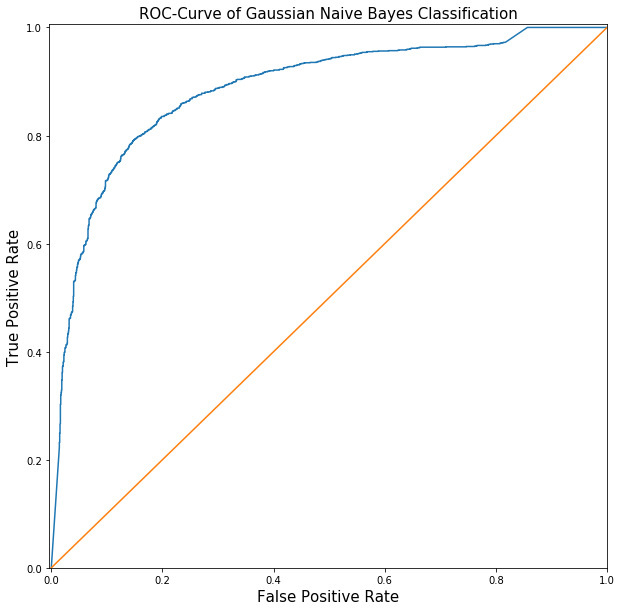

In [81]:
fpr,tpr,threshold=roc_curve(actual_class_GNB,predict_probability_GNB)
line=[0,1]
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC-Curve of Gaussian Naive Bayes Classification',fontsize=15)
plt.axis([-0.004,1,0,1.006])
plt.show()

## Multinomial NB

In [82]:
all_train=fetch_20newsgroups(subset='train',categories=computer_subclass+rec_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
all_test=fetch_20newsgroups(subset='test',categories=computer_subclass+rec_subclass,shuffle=True,random_state=42,remove=('headers','footers','quotes'))
all_data=all_train.data+all_test.data

In [83]:
preprocessing(all_train.data)
preprocessing(all_test.data)

Creating TFIDF matrix

In [86]:
count_vect=CountVectorizer(min_df=2,stop_words ='english')
X_counts_MNNB=count_vect.fit_transform(all_train.data)

#Feature extraction using TFxIDF
tfidf_transformer=TfidfTransformer()
X_tfidf_MNNB=tfidf_transformer.fit_transform(X_counts_MNNB)

all_train.target

array([6, 7, 4, ..., 6, 6, 2], dtype=int64)

In [87]:
all_test.target

array([3, 2, 3, ..., 7, 1, 1], dtype=int64)

Create instance of Multinomial NB

In [88]:
clf=MultinomialNB()
clf.fit(X_tfidf_MNNB,all_train.target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [89]:
X_new_counts = count_vect.transform(all_test.data)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted_class_MNNB = clf.predict(X_new_tfidf)
actual_class_MNNB = all_test.target
predicted_class_MNNB

array([3, 2, 0, ..., 4, 1, 1], dtype=int64)

In [90]:
print('Classification report:')
print(metrics.classification_report(actual_class_MNNB,predicted_class_MNNB,
                                    target_names=['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware',
                                                                              'rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']),)

Classification report:
                          precision    recall  f1-score   support

           comp.graphics       0.77      0.79      0.78       389
 comp.os.ms-windows.misc       0.74      0.62      0.68       394
comp.sys.ibm.pc.hardware       0.66      0.76      0.71       392
   comp.sys.mac.hardware       0.80      0.69      0.74       385
               rec.autos       0.83      0.83      0.83       396
         rec.motorcycles       0.88      0.81      0.84       398
      rec.sport.baseball       0.93      0.83      0.88       397
        rec.sport.hockey       0.72      0.94      0.81       399

               micro avg       0.79      0.79      0.79      3150
               macro avg       0.79      0.78      0.78      3150
            weighted avg       0.79      0.79      0.78      3150



In [91]:
print('Confusion Matrix:')
print(metrics.confusion_matrix(actual_class_MNNB,predicted_class_MNNB))



Confusion Matrix:
[[307  24  21  16   8   5   1   7]
 [ 46 246  59  12   6   8   1  16]
 [ 13  38 297  31   3   1   0   9]
 [ 15  19  53 267   9   4   1  17]
 [  2   2   2   2 328  19   8  33]
 [  6   0   6   5  31 323   6  21]
 [  9   2   6   0   3   3 331  43]
 [  3   1   3   1   6   4   7 374]]


In [92]:
print('Total accuracy: ')
print(np.mean(actual_class==predicted_class))

Total accuracy: 
0.785079365079365


## Bernouilli NB

In [93]:
classifier_BNB = BernoulliNB()

We will fit LSI_train_SVD with labelled data of classification_train_SVD.

In [95]:
classifier_BNB.fit(LSI_train_SVD, classification_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

We will now predict on LSI_test_SVD

In [97]:
predicted_class_BNB=classifier_BNB.predict(LSI_test_SVD)
actual_class_BNB = classification_test

In [98]:
predict_probability_BNB=classifier_BNB.predict_proba(LSI_test_SVD[:])[:,1]
predict_probability_BNB

array([0.09255328, 0.93471593, 0.7692961 , ..., 0.19175852, 0.22421953,
       0.23004187])

In [99]:
print('Classification report:')
print(metrics.classification_report(actual_class_BNB,predicted_class_BNB,target_names=["Com Tech","Rec Act"]),)

Classification report:
              precision    recall  f1-score   support

    Com Tech       0.86      0.89      0.88      1590
     Rec Act       0.89      0.85      0.87      1560

   micro avg       0.87      0.87      0.87      3150
   macro avg       0.87      0.87      0.87      3150
weighted avg       0.87      0.87      0.87      3150



In [100]:
print('Confusion Matrix:')
print(metrics.confusion_matrix(actual_class_BNB,predicted_class_BNB))

Confusion Matrix:
[[1417  173]
 [ 227 1333]]


In [101]:
print('Total accuracy: ')
print(np.mean(actual_class_BNB==predicted_class_BNB))


Total accuracy: 
0.873015873015873


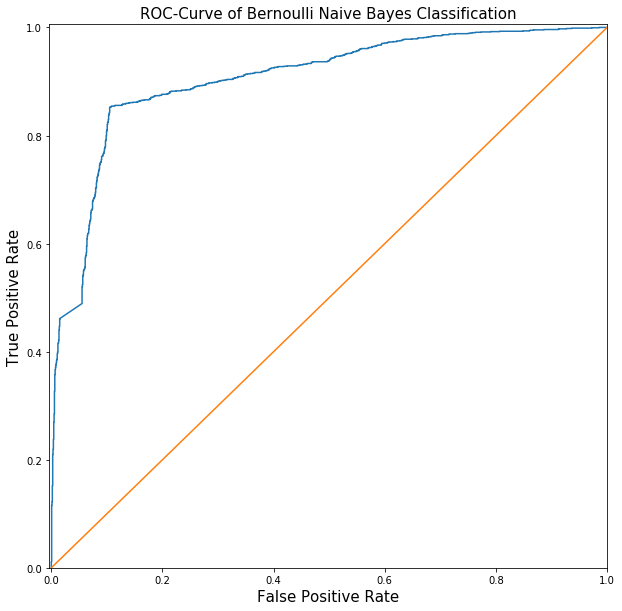

In [102]:
fpr,tpr,threshold=roc_curve(actual_class_BNB,predict_probability_BNB)
line=[0,1]
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC-Curve of Bernoulli Naive Bayes Classification',fontsize=15)
plt.axis([-0.004,1,0,1.006])
plt.show()

# Logistic Regression

Even though 'Logistic Regression' has regression in its name, it has nothing to do with regression. It is historically named like that. It is basically a classification algorithm. Let's use it to classify our two classes. 'Computer Technology' and 'Recreational Activity'.

We need to know the basics, right? What is logistic regression? 

Logistic function used in this algorithm is a sigmoid function that takes any read number and maps it to any value between 0 and 1, but not at 0 and 1. It is defined as: 
$$f(x) =  \frac{1}{1+e^{-x}}$$

<img src= "..jupyter_codes/Logistic-Function.png" />

In [106]:
from sklearn.linear_model import LogisticRegression

Let's first create an instance of class

In [107]:
classifier_LR = LogisticRegression()

We have already removed the punctuations, stopwords and also stemmed it using SnowBallStemmer. We have also reduced the dimensions to 50 using SVD. So, let's directly use this so that model can learn it on training data.

In [109]:
classifier_LR.fit(LSI_train_SVD, classification_train)

C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Now, let's predict our model on test data.

In [110]:
predicted_class_LR = classifier_LR.predict(LSI_test_SVD)

In [111]:
predicted_class_LR

array([-1,  1,  1, ..., -1, -1, -1])

In [112]:
predicted_class_LR.shape

(3150,)

So, we have predicted our model. Let's analyse its performance using previously mentioned methods.

In [126]:
actual_class_LR = classification_test
len(actual_class_LR)

3150

We will predict the probability of our predicted class.

In [119]:
LSI_test_SVD.shape

(3150, 50)

In [121]:
predict_probability_LR = classifier_LR.predict_proba(LSI_test_SVD[:])[:,1]

In [122]:
predict_probability_LR

array([0.34705868, 0.91122453, 0.90446888, ..., 0.17087272, 0.24539349,
       0.0459891 ])

In [123]:
predict_probability_LR.shape

(3150,)

In [127]:
print('Classification report:')
print(metrics.classification_report(actual_class_LR, predicted_class_LR, target_names = ["Comp Tech", "Rec Act"]))

Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.90      0.97      0.93      1590
     Rec Act       0.97      0.89      0.93      1560

   micro avg       0.93      0.93      0.93      3150
   macro avg       0.93      0.93      0.93      3150
weighted avg       0.93      0.93      0.93      3150



In [133]:
print('Confusion Matrix:')
print(metrics.confusion_matrix(actual_class_LR, predicted_class_LR))
conf_mat = metrics.confusion_matrix(actual_class_LR, predicted_class_LR)

Confusion Matrix:
[[1546   44]
 [ 176 1384]]


In [132]:
#help(metrics.confusion_matrix)

Let's find out TP, FP, TN, FN

In [136]:
conf_mat

array([[1546,   44],
       [ 176, 1384]], dtype=int64)

True Positives = Class Comp Tech

True Negatives = Class Rec Act

In [148]:
TP = conf_mat[1,1]
FP = conf_mat[0,1]
TN = conf_mat[0,0]
FN = conf_mat[1,0]

1384

In [140]:
print('Total accuracy: ')
print(np.mean(actual_class_LR == predicted_class_LR))

Total accuracy: 
0.9301587301587302


Let's plot our beloved ROC curve

In [149]:
fpr, tpr, threshold = roc_curve(actual_class_LR, predicted_class_LR)

In [150]:
threshold

array([ 2,  1, -1])

In [151]:
line=[0,1]
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

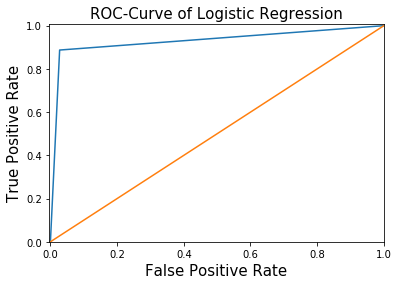

In [152]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.title('ROC-Curve of Logistic Regression',fontsize=15)
plt.axis([-0.004,1,0,1.006])
plt.show()

 ## Regularization: L1 and L2

We will now use L1 and L2 regularization on Logistic Regression classifier and observe its effects on accuracy.

C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

PENALTY TYPE: l1 norm regularization
REGULARIZATION TERM: 0.0001
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.50      1.00      0.67      1590
     Rec Act       0.00      0.00      0.00      1560

   micro avg       0.50      0.50      0.50      3150
   macro avg       0.25      0.50      0.34      3150
weighted avg       0.25      0.50      0.34      3150

Confusion matrix
[[1590    0]
 [1560    0]]
Accuracy
0.5047619047619047


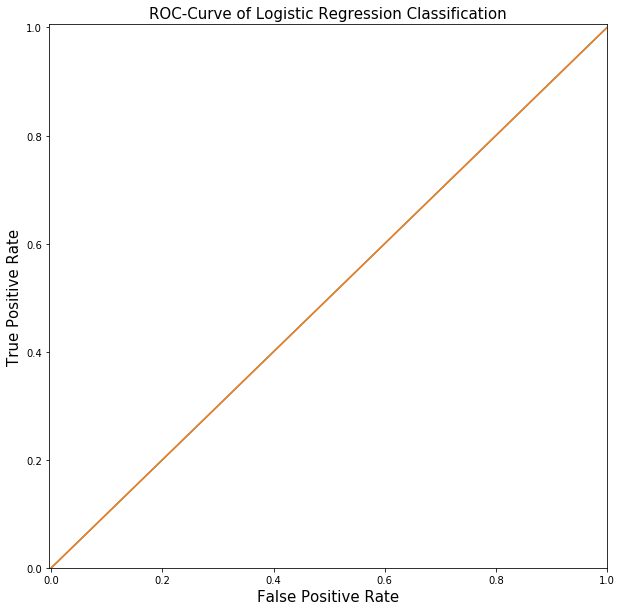




PENALTY TYPE: l2 norm regularization
REGULARIZATION TERM: 0.0001
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.54      1.00      0.70      1590
     Rec Act       1.00      0.12      0.21      1560

   micro avg       0.56      0.56      0.56      3150
   macro avg       0.77      0.56      0.46      3150
weighted avg       0.77      0.56      0.46      3150

Confusion matrix
[[1590    0]
 [1373  187]]
Accuracy
0.5641269841269841


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


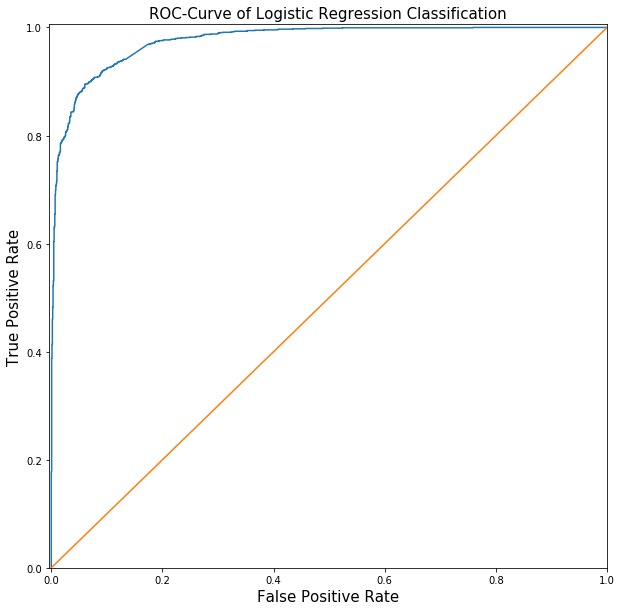




PENALTY TYPE: l1 norm regularization
REGULARIZATION TERM: 0.001
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.50      1.00      0.67      1590
     Rec Act       0.00      0.00      0.00      1560

   micro avg       0.50      0.50      0.50      3150
   macro avg       0.25      0.50      0.34      3150
weighted avg       0.25      0.50      0.34      3150

Confusion matrix
[[1590    0]
 [1560    0]]
Accuracy
0.5047619047619047


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


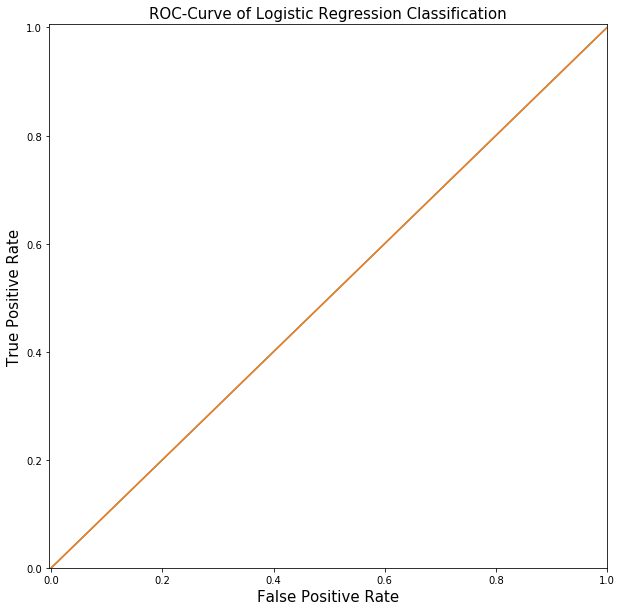




PENALTY TYPE: l2 norm regularization
REGULARIZATION TERM: 0.001
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.65      1.00      0.79      1590
     Rec Act       1.00      0.44      0.61      1560

   micro avg       0.72      0.72      0.72      3150
   macro avg       0.82      0.72      0.70      3150
weighted avg       0.82      0.72      0.70      3150

Confusion matrix
[[1587    3]
 [ 866  694]]
Accuracy
0.7241269841269842


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


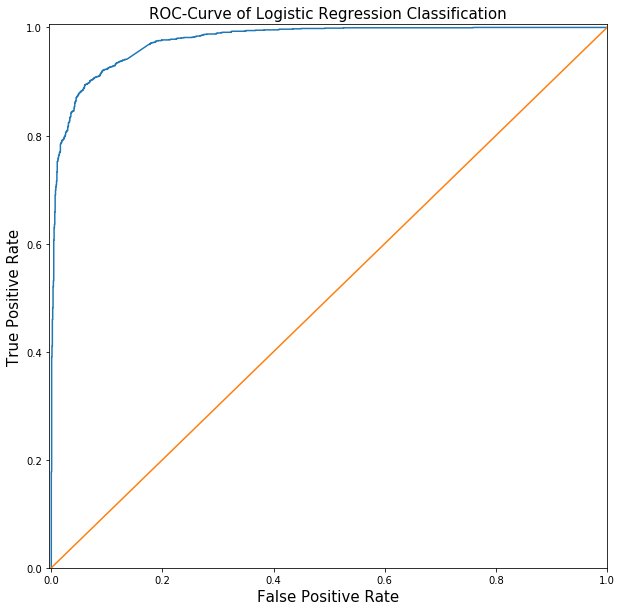




PENALTY TYPE: l1 norm regularization
REGULARIZATION TERM: 0.01
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.84      0.93      0.89      1590
     Rec Act       0.92      0.82      0.87      1560

   micro avg       0.88      0.88      0.88      3150
   macro avg       0.88      0.88      0.88      3150
weighted avg       0.88      0.88      0.88      3150

Confusion matrix
[[1483  107]
 [ 274 1286]]
Accuracy
0.8790476190476191


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


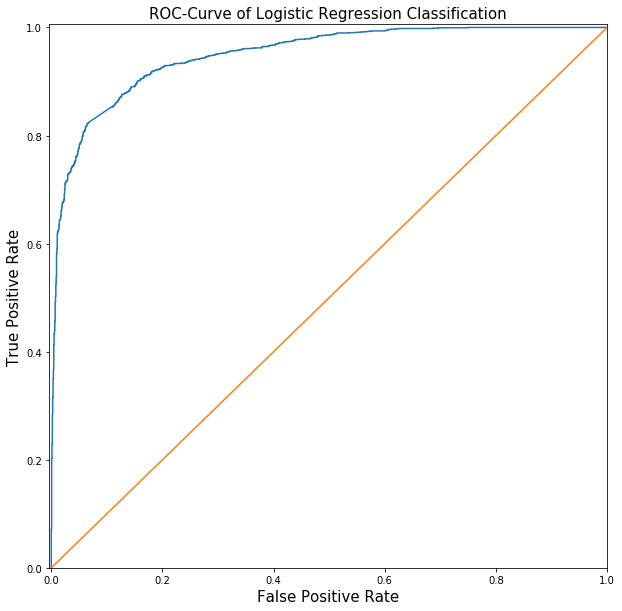




PENALTY TYPE: l2 norm regularization
REGULARIZATION TERM: 0.01
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.82      0.98      0.89      1590
     Rec Act       0.98      0.78      0.87      1560

   micro avg       0.88      0.88      0.88      3150
   macro avg       0.90      0.88      0.88      3150
weighted avg       0.90      0.88      0.88      3150

Confusion matrix
[[1564   26]
 [ 343 1217]]
Accuracy
0.8828571428571429


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


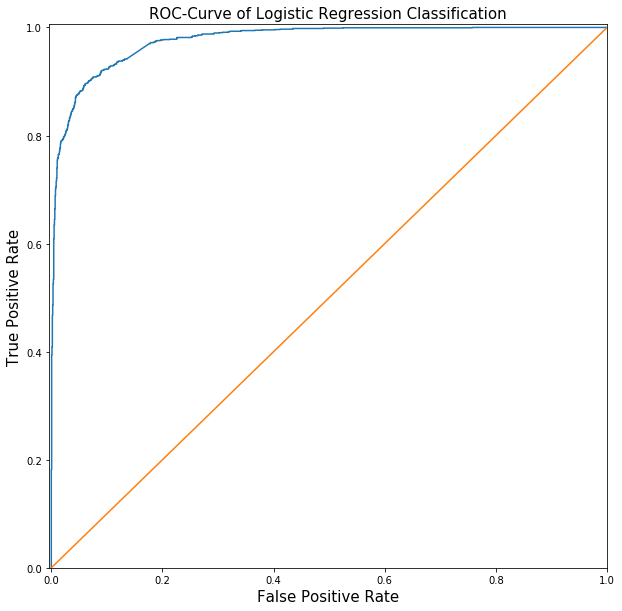




PENALTY TYPE: l1 norm regularization
REGULARIZATION TERM: 0.1
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.87      0.94      0.90      1590
     Rec Act       0.93      0.86      0.89      1560

   micro avg       0.90      0.90      0.90      3150
   macro avg       0.90      0.90      0.90      3150
weighted avg       0.90      0.90      0.90      3150

Confusion matrix
[[1489  101]
 [ 217 1343]]
Accuracy
0.8990476190476191


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


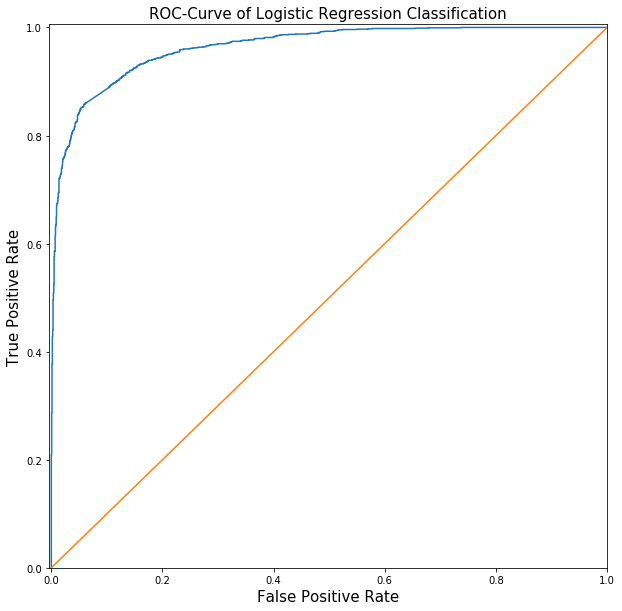




PENALTY TYPE: l2 norm regularization
REGULARIZATION TERM: 0.1
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.86      0.97      0.91      1590
     Rec Act       0.96      0.84      0.90      1560

   micro avg       0.91      0.91      0.91      3150
   macro avg       0.91      0.91      0.91      3150
weighted avg       0.91      0.91      0.91      3150

Confusion matrix
[[1541   49]
 [ 245 1315]]
Accuracy
0.9066666666666666


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


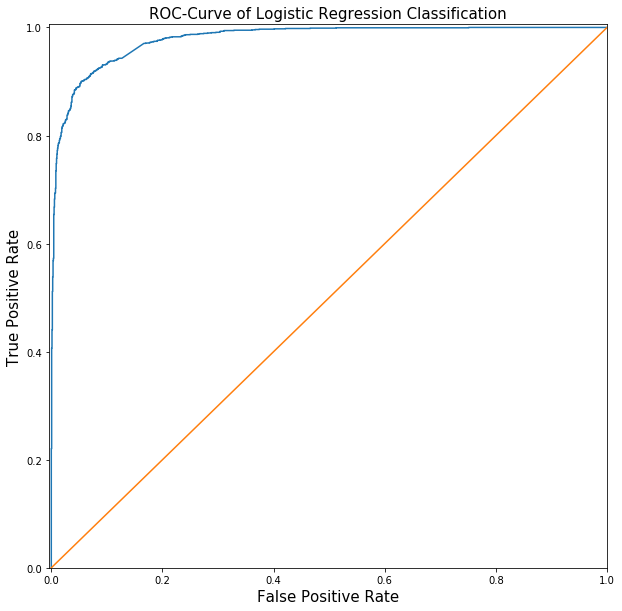




PENALTY TYPE: l1 norm regularization
REGULARIZATION TERM: 1
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.91      0.96      0.94      1590
     Rec Act       0.96      0.90      0.93      1560

   micro avg       0.93      0.93      0.93      3150
   macro avg       0.94      0.93      0.93      3150
weighted avg       0.94      0.93      0.93      3150

Confusion matrix
[[1533   57]
 [ 149 1411]]
Accuracy
0.9346031746031747


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


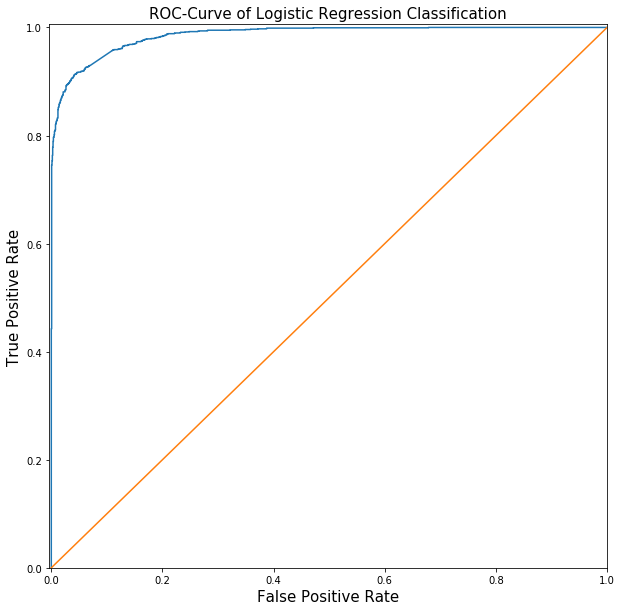




PENALTY TYPE: l2 norm regularization
REGULARIZATION TERM: 1
Classification report:
              precision    recall  f1-score   support

   Comp Tech       0.90      0.97      0.93      1590
     Rec Act       0.97      0.89      0.93      1560

   micro avg       0.93      0.93      0.93      3150
   macro avg       0.93      0.93      0.93      3150
weighted avg       0.93      0.93      0.93      3150

Confusion matrix
[[1546   44]
 [ 176 1384]]
Accuracy
0.9301587301587302


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


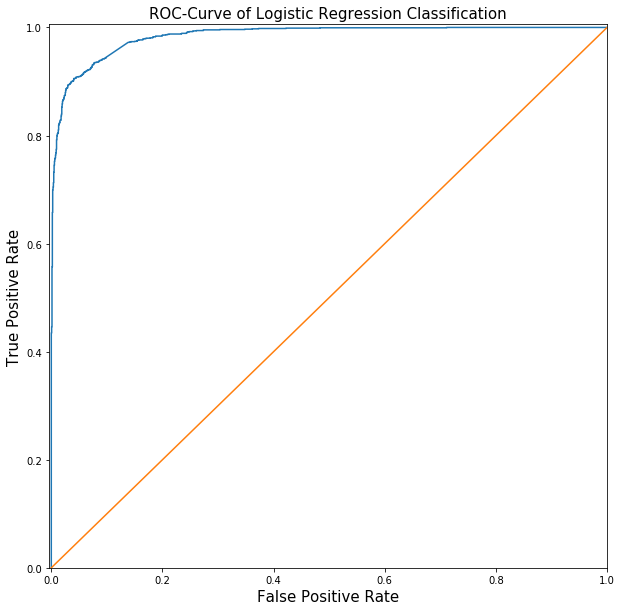

C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

In [162]:
def accuracy_regularization(regularization,penalization):
    classifier_LR=LogisticRegression(C=regularization,penalty=penalization)
    classifier_LR.fit(LSI_train_SVD,classification_train)
    
    predicted_class_LR = classifier_LR.predict(LSI_test_SVD)
    actual_class_LR = classification_test
    predict_probability_LR = classifier_LR.predict_proba(LSI_test_SVD[:])[:,1]
    
    #Only print details of these regularization terms
    if regularization >=0.0001 and regularization <=1:
        line1='REGULARIZATION TERM: ' + str(regularization)
        line2='PENALTY TYPE: ' + penalization +' norm regularization'
        print(line2)
        print(line1)
        
        print('Classification report:')
        print(metrics.classification_report(actual_class_LR, predicted_class_LR, target_names = ["Comp Tech", "Rec Act"]))
        
        print('Confusion matrix')
        print(metrics.confusion_matrix(actual_class_LR, predicted_class_LR))
        
        print('Accuracy')
        print(np.mean(actual_class_LR == predicted_class_LR))
        
        fpr,tpr,threshold=roc_curve(actual_class_LR,predict_probability_LR)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.plot([0,1],[0,1])
        plt.ylabel('True Positive Rate',fontsize=15)
        plt.xlabel('False Positive Rate',fontsize=15)
        plt.title('ROC-Curve of Logistic Regression Classification',fontsize=15)
        plt.axis([-0.004,1,0,1.006])
        plt.show()        
        print('\n\n')
        
    return np.mean(actual_class_LR==predicted_class_LR)

#Now, writing the code block for analysing the effect of varying the norm and the regularization parameter
accuracy_l1=[]
accuracy_l2=[]

#Varying the parameters
for i in range(-6,7):
    accuracy_l1.append(accuracy_regularization(pow(10,i),'l1'))
    accuracy_l2.append(accuracy_regularization(pow(10,i),'l2'))
   


In [163]:
accuracy_l1

[0.5047619047619047,
 0.5047619047619047,
 0.5047619047619047,
 0.5047619047619047,
 0.8790476190476191,
 0.8990476190476191,
 0.9346031746031747,
 0.9428571428571428,
 0.9434920634920635,
 0.9441269841269841,
 0.9441269841269841,
 0.9441269841269841,
 0.9441269841269841]

<Figure size 432x288 with 0 Axes>

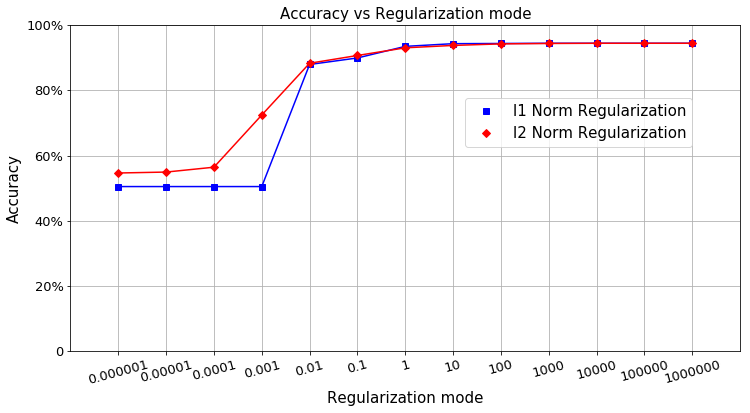

In [164]:
plt.clf()
plt.figure(figsize=(12,6))
x_labels=['0.000001','0.00001','0.0001','0.001','0.01','0.1','1','10','100','1000','10000','100000','1000000']
plt.xticks(range(-6,7),x_labels,fontsize=13,rotation=15)
y_labels=['0','20%','40%','60%','80%','100%']
plt.yticks([0,0.2,0.4,0.6,0.8,1],y_labels,fontsize=13)
plt.plot(range(-6,7),accuracy_l1,'s',label='l1 Norm Regularization',c='blue')
plt.plot(range(-6,7),accuracy_l1,c='blue')
plt.plot(range(-6,7),accuracy_l2,'D',label='l2 Norm Regularization',c='red')
plt.plot(range(-6,7),accuracy_l2,c='red')
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Regularization mode',fontsize=15)
plt.title('Accuracy vs Regularization mode',fontsize=15)
plt.axis([-7,7,0,1])
plt.grid(True)
plt.legend(loc='upper right',bbox_to_anchor=(0.94,0.8),fontsize=15,numpoints=1)
plt.show()


L1 and L2 regularization are two closely related techniques used by machine learning algorithms to reduced overfitting.

**Results of what we did before:**

* L2 norm LR performs better than L1 norm LR. As regularization increases, accuracy increases as can be in accuracy-regularization plot. After regularization becomes greater than 0.01, we got a stable accuracy of nearly 93%
